Here I generate data for fitting the ode model by picking an initial height, length of trial, and thinning rate (d, ts, v). I keep the f0=0.001737140 (the same as the evaporative case for which we have data). I solve the ode, and take the solution for intensity, add noise, and save as a csv.

In [77]:
#@title
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import solve_ivp
from scipy.optimize import minimize


In [78]:
#@title
# Functions needed 
def intensity(thickness, phi, f, I_0):
  I = I_0*(1-np.exp(- phi*f0))/(1+np.square(np.divide(f0,thickness)))
  return I;

def solveTF(t_begin, t_end, t_nsamples, t_space, h_init, Pc, f0, I_0, v): 
  thickness = np.zeros(t_nsamples)
  method = 'RK45' #available methods: 'RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA'
  num_sol = solve_ivp(ode_fn(v,Pc), [t_begin, t_end], [h_init], method=method, dense_output=True)
  thickness = num_sol.sol(t_space)

  #return thickness, 1/thickness, f0/thickness, intensity(thickness, phi, f0, I_0);
  return thickness, 1/thickness, f0/thickness, intensity(thickness, phi, f0/thickness, I_0);

# Calulates the RHS of the ode - depends on value of v and Pc
def ode_fn(v,Pc):
  return lambda t, h : - v + Pc*(1/h - 1);

def objective(v, t_begin, t_end, t_nsamples, t_space, h_init, Pc, f0, I_0):
  #(v)
  thickness, c, f, I = solveTF(t_begin, t_end, t_nsamples, t_space, h_init, Pc, f0, I_0, v)
 # print(I)
  SS = np.linalg.norm(I - test[1,:])**2/t_nsamples
  #print(SS)
  return SS

def thickness_plot(t_space, thickness, d, ax): 
  ax.plot(t_space, thickness.T, '-', linewidth=2,label='predicted')
  ax.set_title('thickness')
  ax.tick_params(bottom=True, top=False, left=True, right=True)
  ax.set_xlabel('$t$')
  ax.set_ylabel('$h$')
  #ax.set_xlim([0, 3])
  #ax.set_ylim([0, 1])
  ax.legend()
  return;

def intensity_plot(t_space, I, ax):
  ax.plot(t_space, I.T, '-', linewidth=2,label='predicted')
  #ax.scatter(test[0,:],test[1,:],label='actual')
  ax.set_title('fluorescent intensity')
  ax.tick_params(bottom=True, top=False, left=True, right=True)
  ax.set_xlabel('$t$')
  ax.set_ylabel('$I$')
  #ax.set_xlim([0, 3])
 # ax.set_ylim([0, 200])
  ax.legend()

def osmolarity_plot(t_mat, c, d, ax):
  ax.plot(t_mat, c.T, '-', linewidth=2,label='predicted')
  ax.set_title('osmolarity')
  ax.tick_params(bottom=True, top=False, left=True, right=True)
  ax.set_xlabel('$t$')
  ax.set_ylabel('$c$')
  #ax.set_xlim([0, 3])
  #ax.set_ylim([0, 8])
  ax.legend()

def fluorescein_plot(t_mat, f, ax):
  ax.plot(t_mat, f.T, '-', linewidth=2,label='predicted')
  ax.set_title('fluorescein')
  ax.tick_params(bottom=True, top=False, left=True, right=True)
  ax.set_xlabel('$t$')
  ax.set_ylabel('$f$')
  #ax.set_xlim([0, 3])
  #ax.set_ylim([0, 8])
  ax.legend()

def thickness_plot_dim(t_dim, thickness, d, ax): 
  thickness_dim = thickness * d
  ax.plot(t_dim, thickness_dim.T, '-', linewidth=2,label='predicted')
  ax.set_title('thickness')
  ax.tick_params(bottom=True, top=False, left=True, right=True)
  ax.set_xlabel('$t\; (s)$')
  ax.set_ylabel('$h\; (\mu m)$')
  #ax.set_xlim([0, 3])
  #ax.set_ylim([0, 1])
  ax.legend()
  return;

def intensity_plot_dim(t_dim, I, test, initial_I, ax):
  I_dim = initial_I*I
  ax.plot(t_dim, I_dim.T, '-', linewidth=2,label='predicted')
  ax.scatter(test[0,:],test[1,:],label='actual')
  ax.set_title('fluorescent intensity')
  ax.tick_params(bottom=True, top=False, left=True, right=True)
  ax.set_xlabel('$t\; (s)$')
  ax.set_ylabel('$intensity$')
  #ax.set_xlim([0, 3])
 # ax.set_ylim([0, 200])
  ax.legend()

def osmolarity_plot_dim(t_dim, c, c0, d, ax):
  c_dim = c * c0 * 1e18 # convert to mol/m^3
  ax.plot(t_dim, c_dim.T, '-', linewidth=2,label='predicted')
  ax.set_title('osmolarity')
  ax.tick_params(bottom=True, top=False, left=True, right=True)
  ax.set_xlabel('$t\; (s)$')
  ax.set_ylabel('$c \;(mol/m^3)$')
  #ax.set_xlim([0, 3])
  #ax.set_ylim([0, 8])
  ax.legend()

def fluorescein_plot_dim(t_dim, f, fcr, d, ax):
  f_dim =  fcr * f * 100 # fl concentation in percent
  ax.plot(t_dim, f_dim.T, '-', linewidth=2,label='predicted')
  ax.set_title('fluorescein')
  ax.tick_params(bottom=True, top=False, left=True, right=True)
  ax.set_xlabel('$t\; (s)$')
  ax.set_ylabel('$f\; (\%)$')
  #ax.set_xlim([0, 3])
  #ax.set_ylim([0, 8])
  ax.legend()

In [79]:
#change these to create new data
d = 2 # initial height in micrometers
ts = 9
v = 4.5*ts/(60*d)

# Define the problem
t_begin=0.
t_end=1.
t_nsamples=5*ts+1
t_space = np.linspace(t_begin, t_end, t_nsamples)
h_init = 1 

#ts=3
fcrM = .0053 # critical fl concentration in Molar which is .2 percent
fcr = .002 # critical fl concentration in mol fraction
e_f = 17.5 # extinction coeff in micrometers^-1 M^-1 (1.75e7 m^-1 M^-1)
Ptiss = 12 # corneal permeability in micrometers/s
Vw = 18e12 # molar volume of water in micrometers^3/mol (18 cm^3/mol)
c0 = 300e-18 # isosmolar concentration in mol/micrometer^3 (300 mol/m^3)
f0 = 0.001737140/fcr # critical fl concentration nondimensionalized

phi = e_f*fcrM*d
Pc = (Ptiss*Vw*c0*ts)/d


I_0 = (1+(f0)**2)/(1-np.exp(-phi*f0*h_init)) # solve for I_0
#v = 7.72*ts/(60*d) #initial guess for thinning rate (8 micrometer/min) scale by ts/(60d)
vmin, vmax = 0, 40*ts/(60*d)
bounds = [(vmin,vmax)]
print('I_0 =',I_0)
print('phi =',phi)
print('Pc =',Pc)
print('v =',v)
print('f0 = ',f0)
print('bounds = ',bounds)

I_0 = 11.789635016829235
phi = 0.1855
Pc = 0.29159999999999997
v = 0.3375
f0 =  0.8685700000000001
bounds =  [(0, 3.0)]


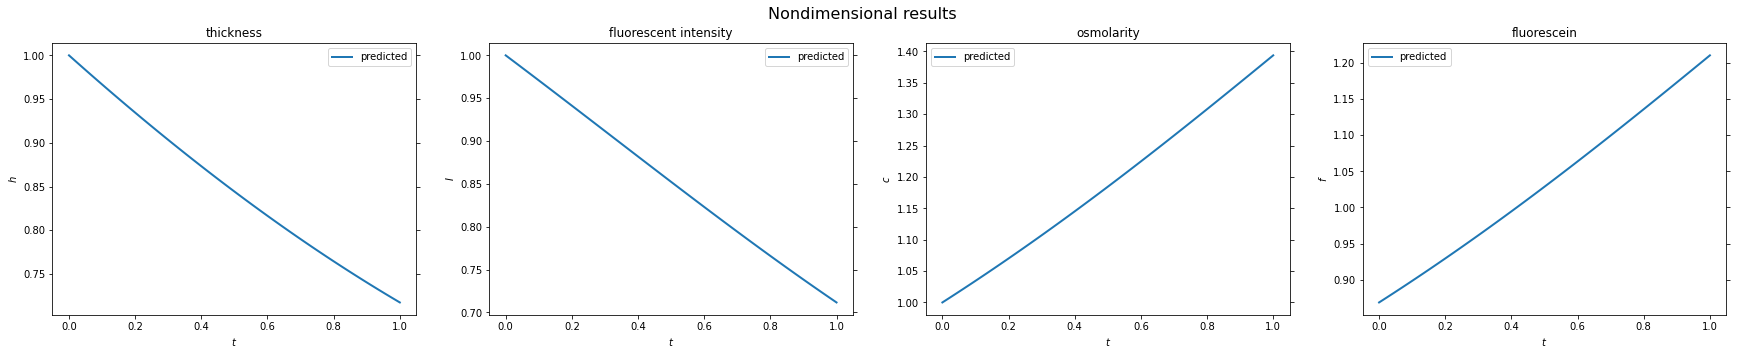

In [80]:
thickness, c, f, I = solveTF(t_begin, t_end, t_nsamples, t_space, h_init, Pc, f0, I_0, v)

fig, ax = plt.subplots (1,4,figsize=(30,5))
thickness_plot(t_space, thickness, d, ax[0])
intensity_plot(t_space, I, ax[1])
osmolarity_plot(t_space, c, d, ax[2])
fluorescein_plot(t_space, f, ax[3])
fig.suptitle('Nondimensional results',fontsize=16)
plt.show()


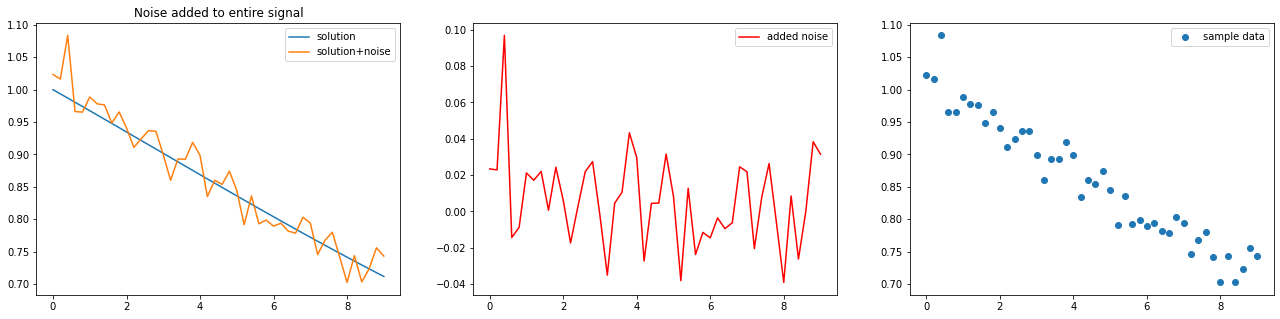

In [81]:
np.random.seed(137)
sample_times=np.linspace(0,ts,5*ts+1)
percentage = .25
n = np.random.normal(0, I.std(), sample_times.size) * percentage
n1 = np.random.normal(0, 1, sample_times.size) * percentage
test_data = I + n

fig = plt.figure(figsize=(30,5))

ax1 = fig.add_subplot(141)
ax1.set_title('Noise added to entire signal')
ax1.plot(sample_times, I.T, label='solution')
ax1.plot(sample_times, test_data.T, label='solution+noise')
plt.legend()

ax2 = fig.add_subplot(142)
ax2.plot(sample_times, n.T, label='added noise', c='r')
plt.legend()

ax4 = fig.add_subplot(143)
ax4.scatter(sample_times, test_data, label='sample data')
plt.legend()
plt.show()

In [82]:
sample1 =np.vstack((sample_times, test_data))

In [83]:
np.savetxt("d2_v4_5_ts9.csv", sample1, delimiter=",")